# Data Exploration
参考：[Exploration & Transforming Images in Python
](https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python)

In [1]:
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

读取文件:部分转化为浮点数，空值？？

In [2]:
train = pd.read_json('../ShipIceberg/Data/train.json')
train['inc_andle']=pd.to_numeric(train['inc_angle'],errors = 'coerce')

全局属性？？？

In [3]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

train['inc_angle']

绘制直方图

In [5]:
def plot_var(name,nbins=50):
    #train[name]=train[name].dropna()
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

+ 由于inc_angle中含有nan项，需要dropna,暂时不考虑该项
+ Missing values is taken as float, whereas others are str
+ 中部50%范围两者的分布差不多，其他均有明显区别
+ We might expect this if, for example, icebergs are much larger than ships and thus cover more pixels.

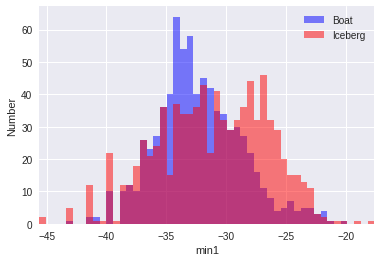

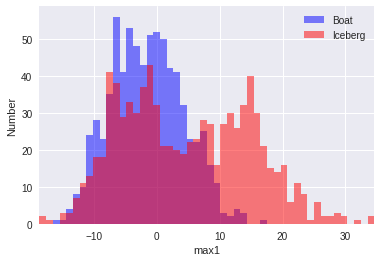

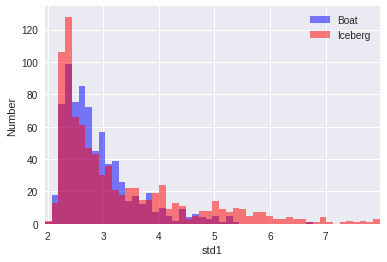

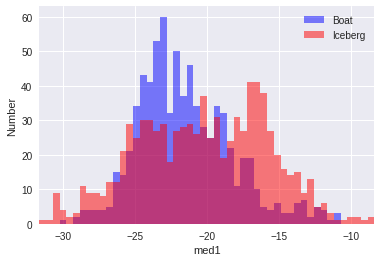

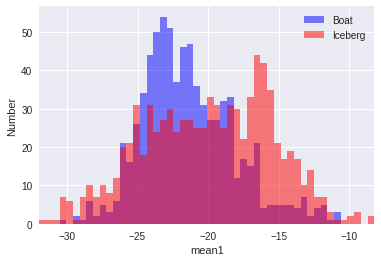

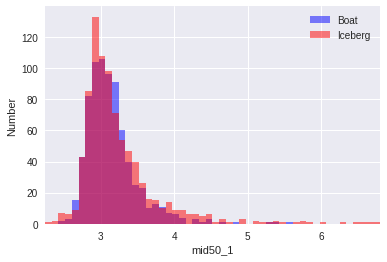

In [6]:
# band_1

for col in ['min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

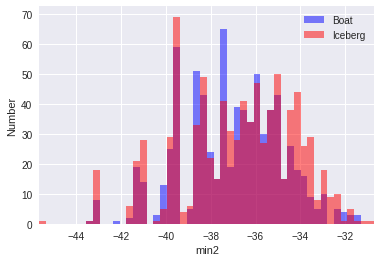

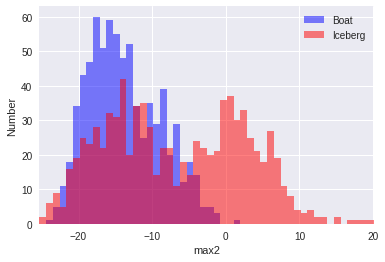

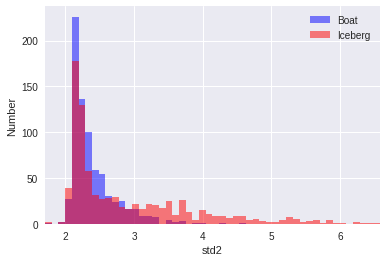

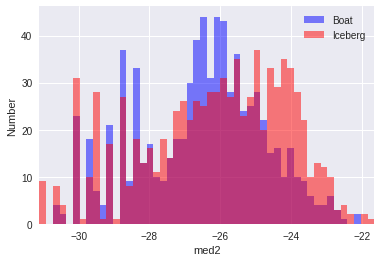

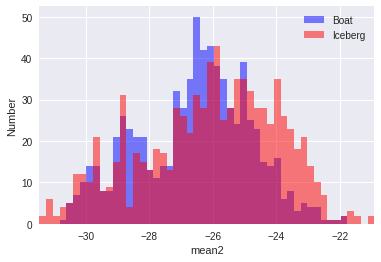

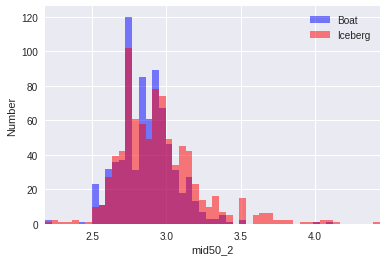

In [7]:
# band_2
for col in['min2','max2','std2','med2','mean2','mid50_2']:
    plot_var(col)

+ 绘制相关矩阵
+ It would also be good to look at scatter plots of each pair of variables (this can be done easily in Seaborn),

In [8]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

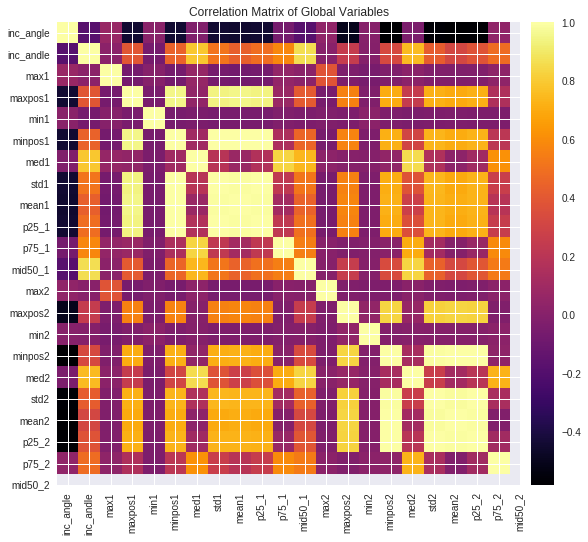

In [9]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

绘制一些图像

In [10]:
icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

9 random icebergs using band 1

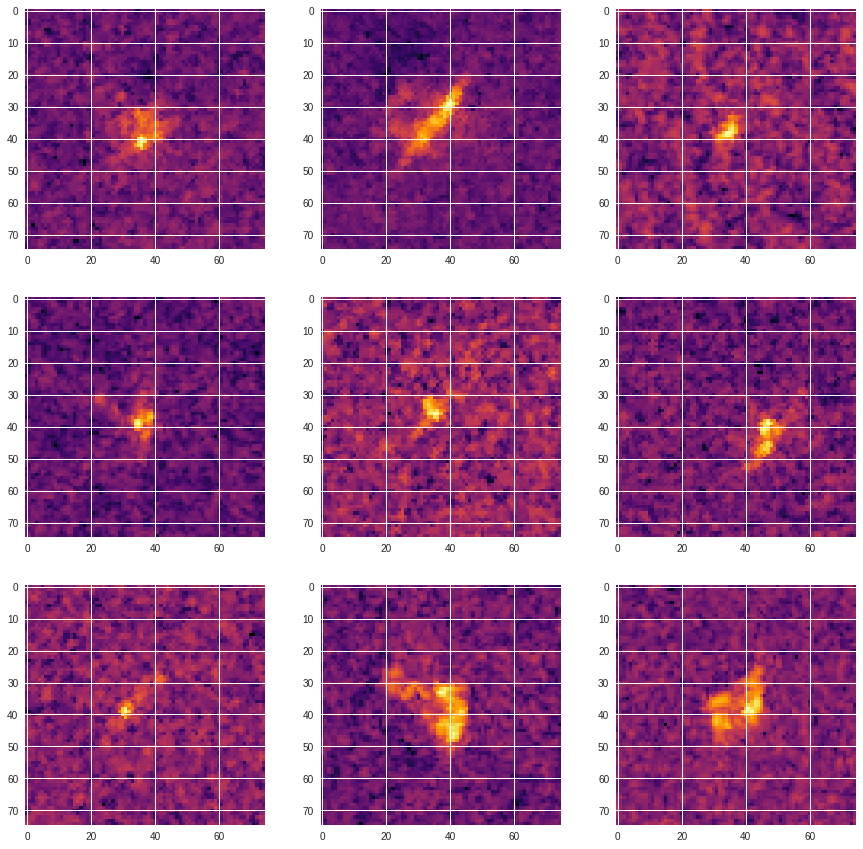

In [11]:
# Plot band_1 icebergs
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

ships in band 1.

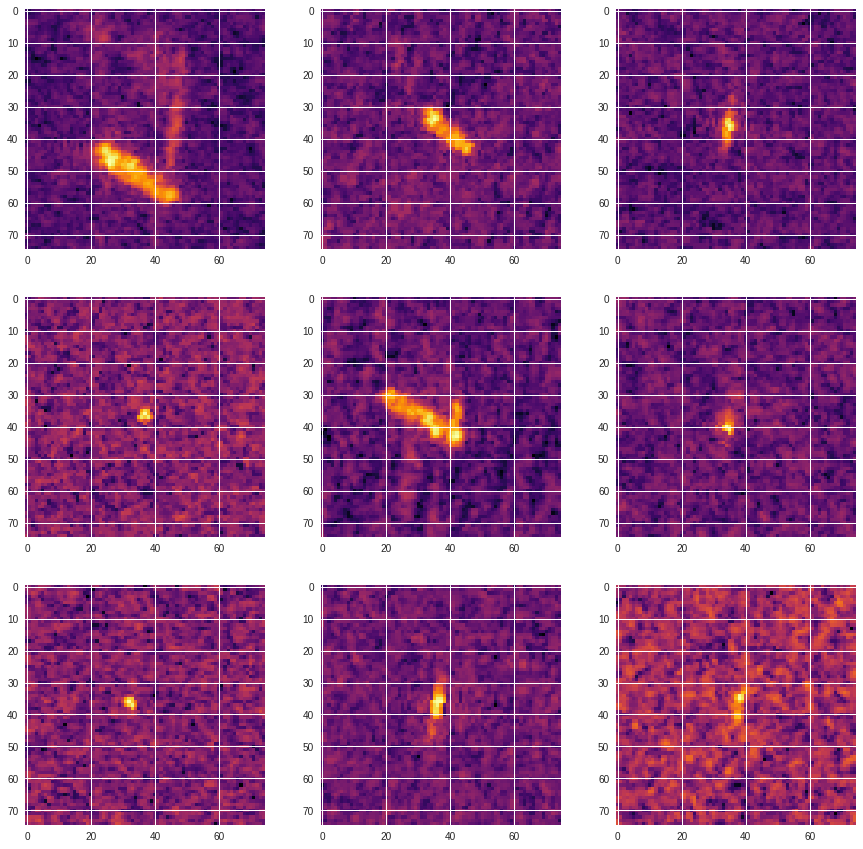

In [12]:
# Plot band_1 ships
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,0]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

the same set of icebergs in band 2.

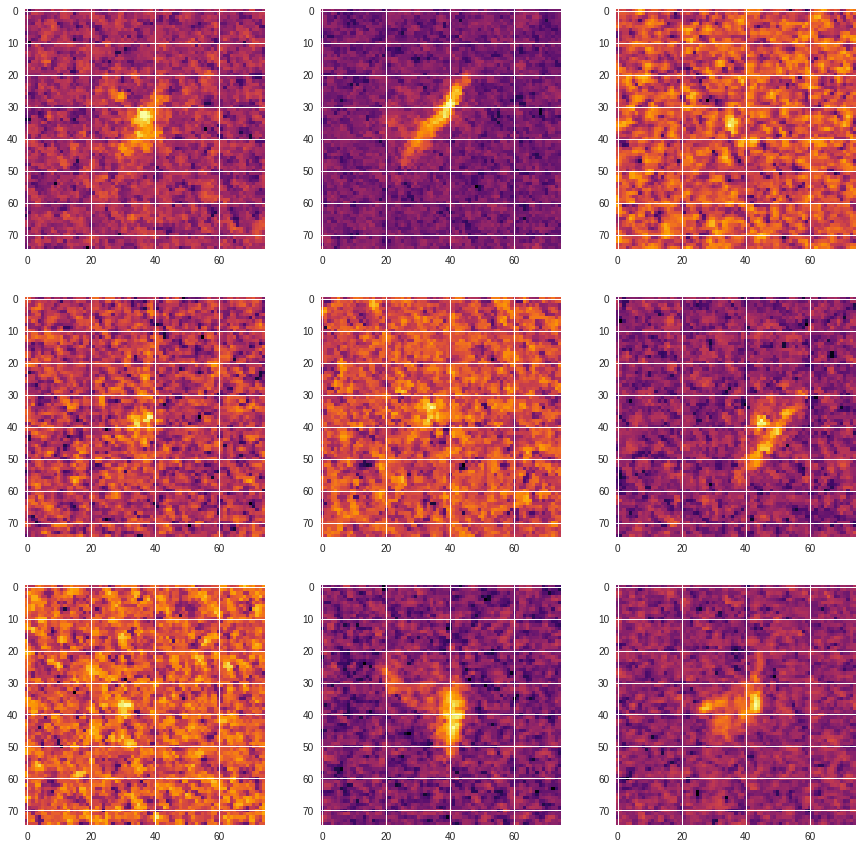

In [13]:
# Plot band_2 icebergs
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

 the same ship images as before, but for band 2.

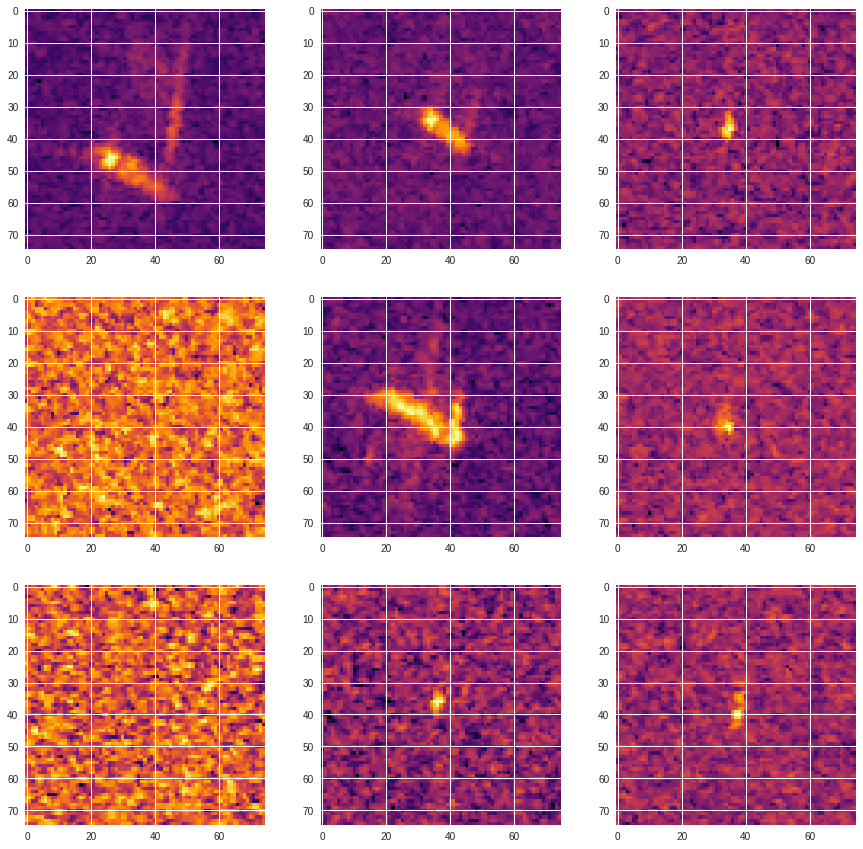

In [14]:
# Plot band_1 ships
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

小结：
+ the background is not really random noise but rather has some spatial correlations
+ The ships seem to have a more regular structure, with a pronounced skewness in the blobs for larger signals
+ it may be advantageous to first transform the images in some way to enhance the contrast between the signals and the background.

图像变换：
+ 下方只是一个例子，需要尝试不同的设置

In [15]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

图像平滑：
+ first plot the icebergs and then the ships. These are all for Band 1.
+ smoothing blurs the features. However, it also enhances the contrast between bright and dark regions, so it may be quite useful if we want to use it to seed some clusters in a cluster/peak finder.

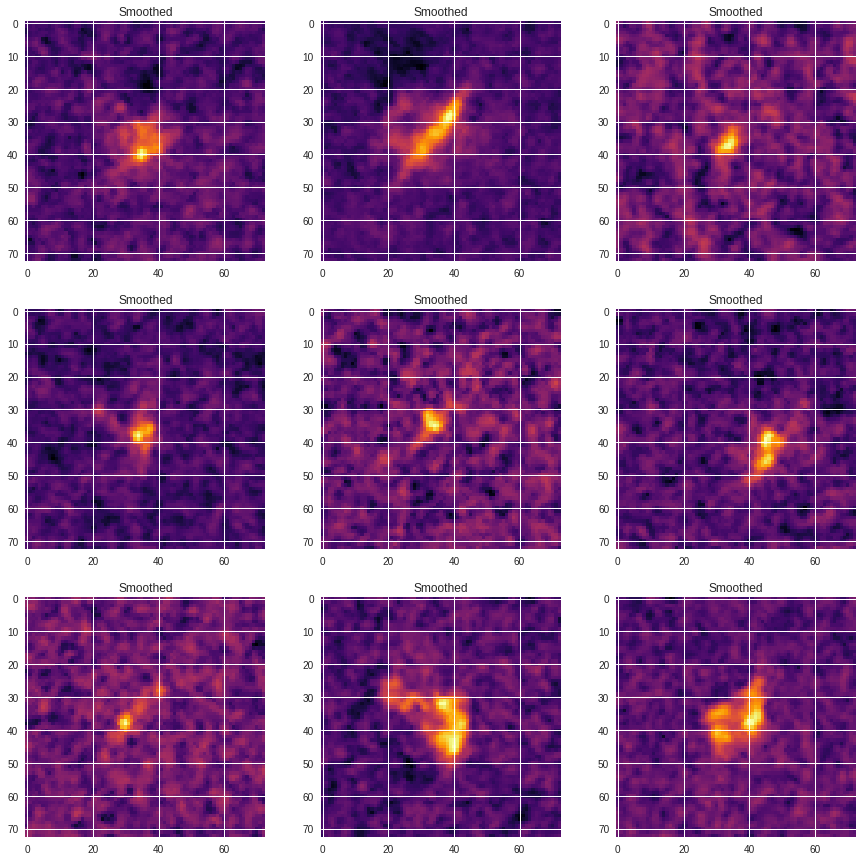

In [16]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

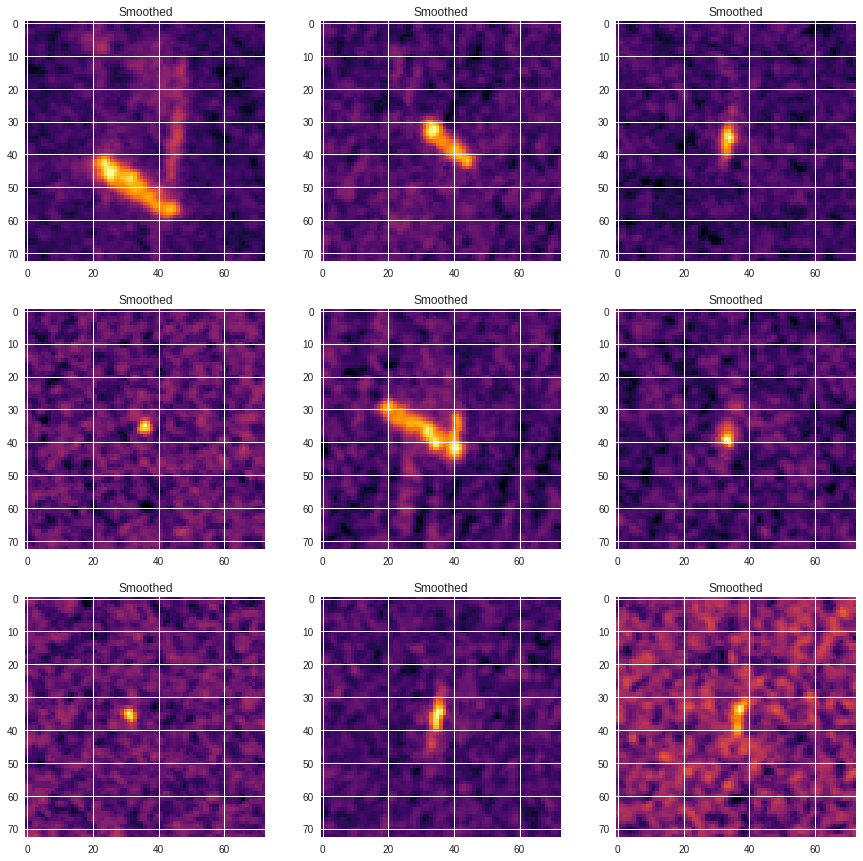

In [17]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),smooth,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('Smoothed')
    
plt.show()

Derivative with Respect to X

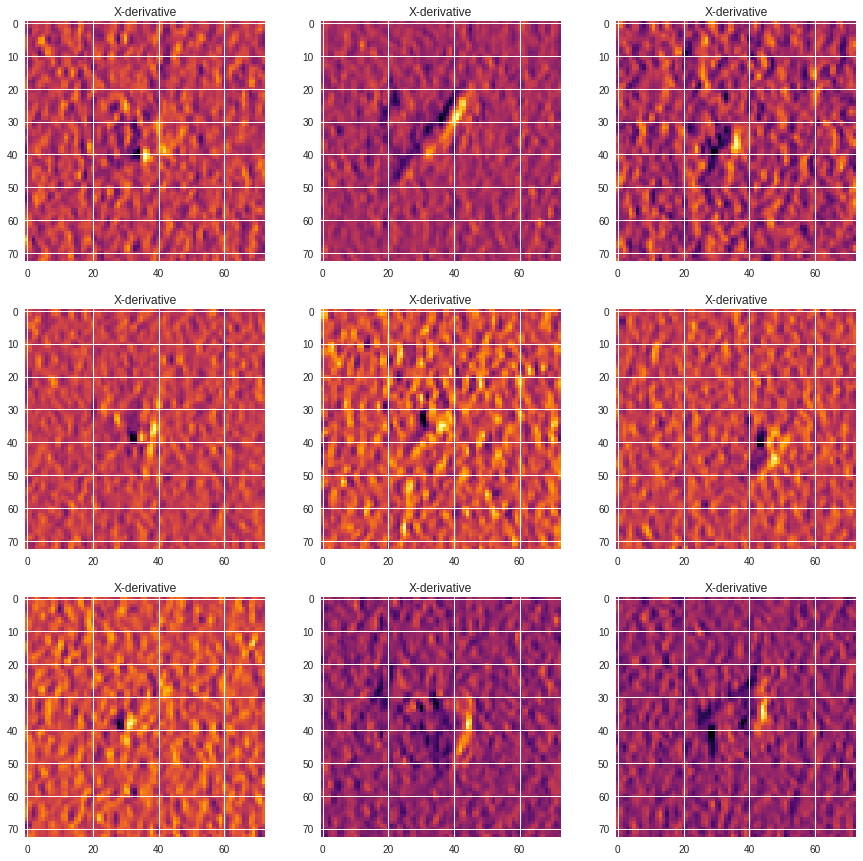

In [18]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

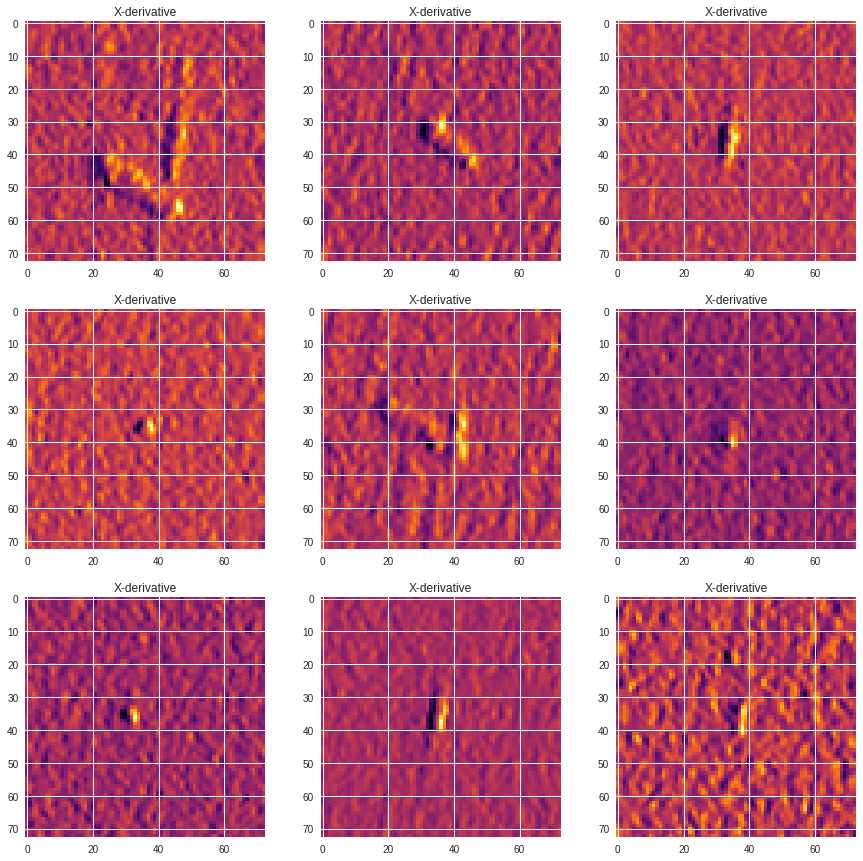

In [19]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title('X-derivative')
    
plt.show()

Gradient Magnitude

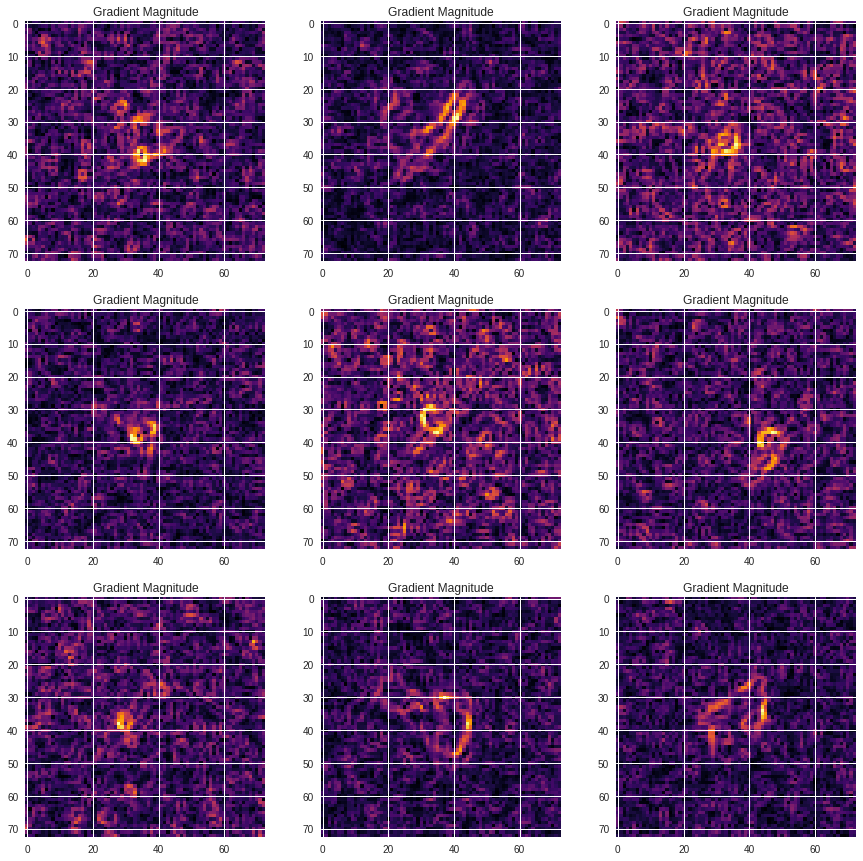

In [20]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

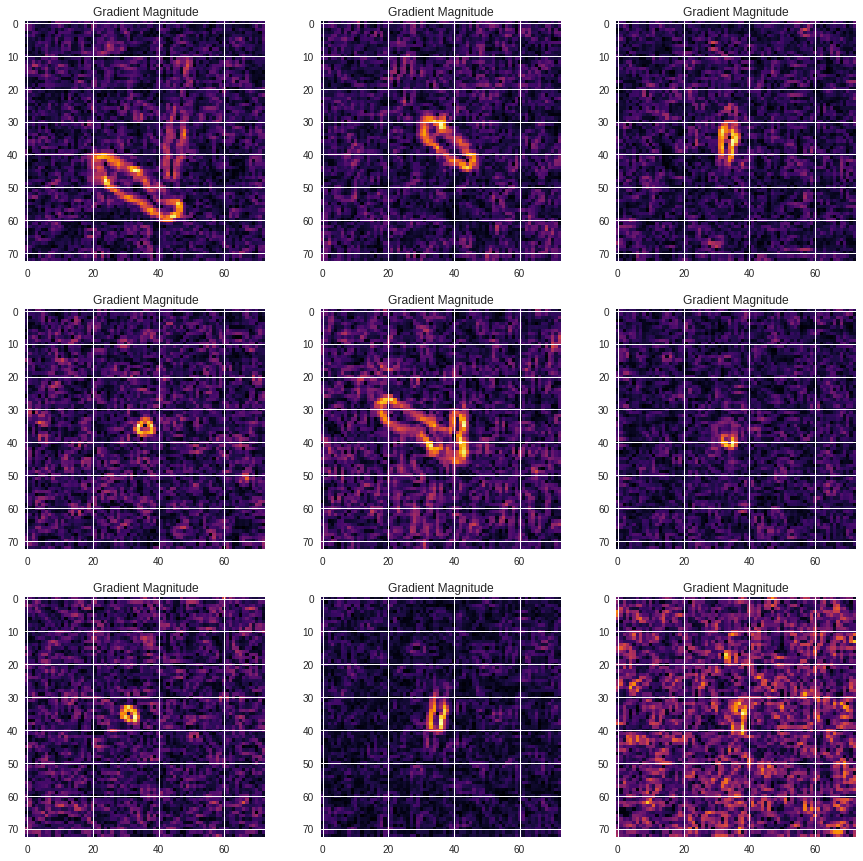

In [21]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

小结：
+ The ships, in particular, show fairly bright edges and most create nice loops
+ At the very least, it would be good to compare the results using this against things like the raw and smoothed data.

Second Derivatives¶

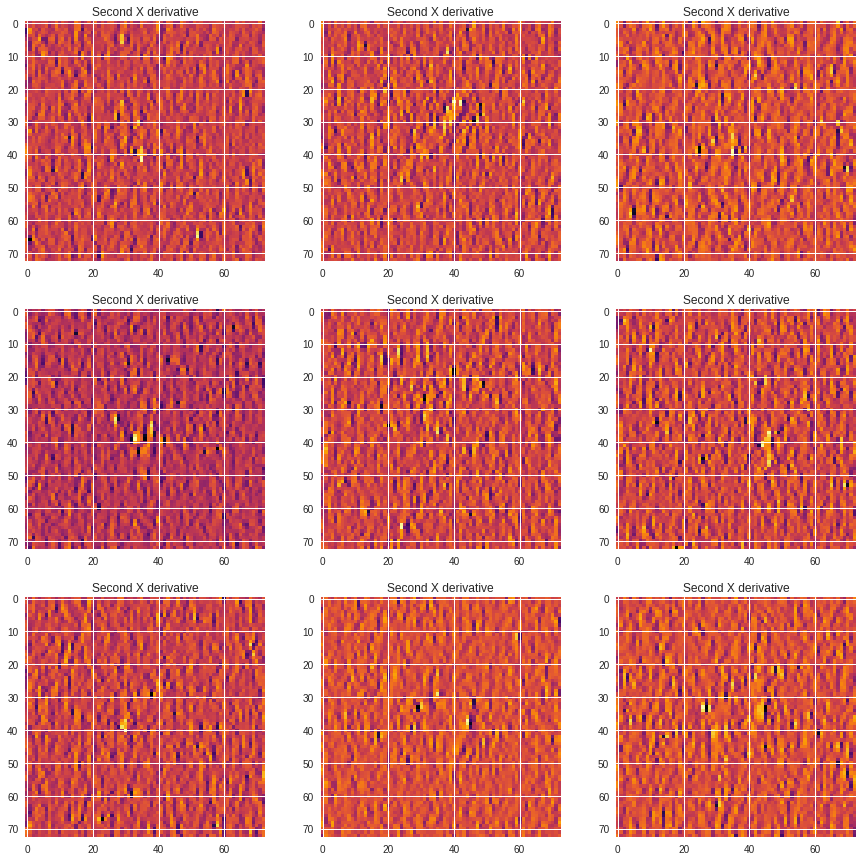

In [22]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

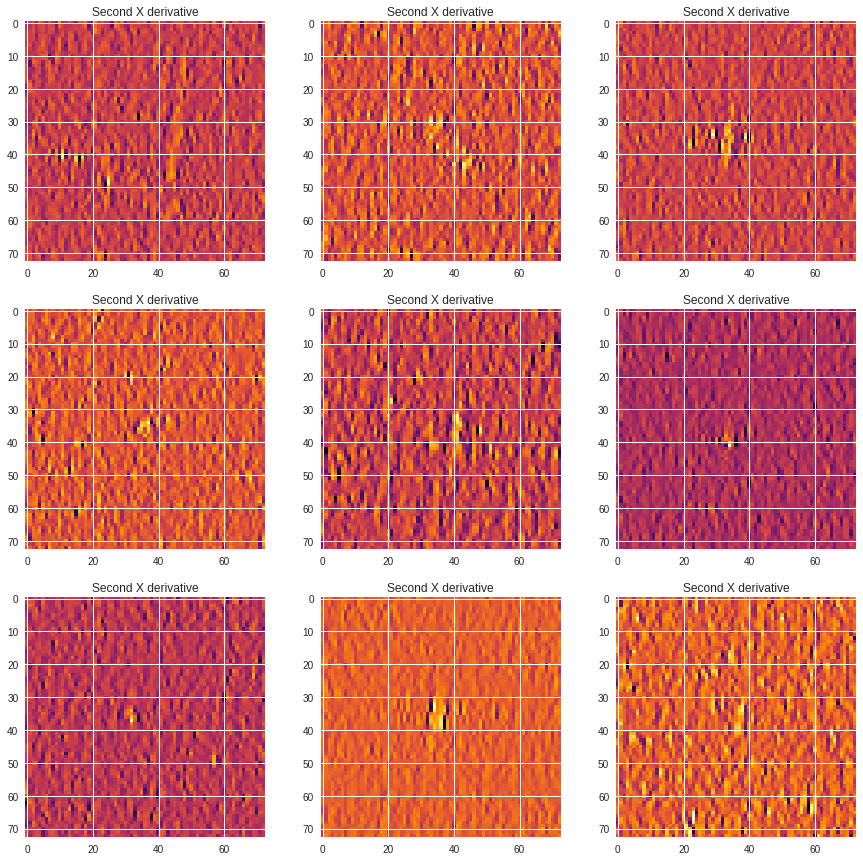

In [23]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder2,mode='valid')
    ax.imshow(arr,cmap='inferno')
    ax.set_title(r'Second X derivative')
    
plt.show()

Laplacian:
+ the sum of second derivatives, or the divergence of the gradient.
+ second derivatives probably require more smoothing to be useful.

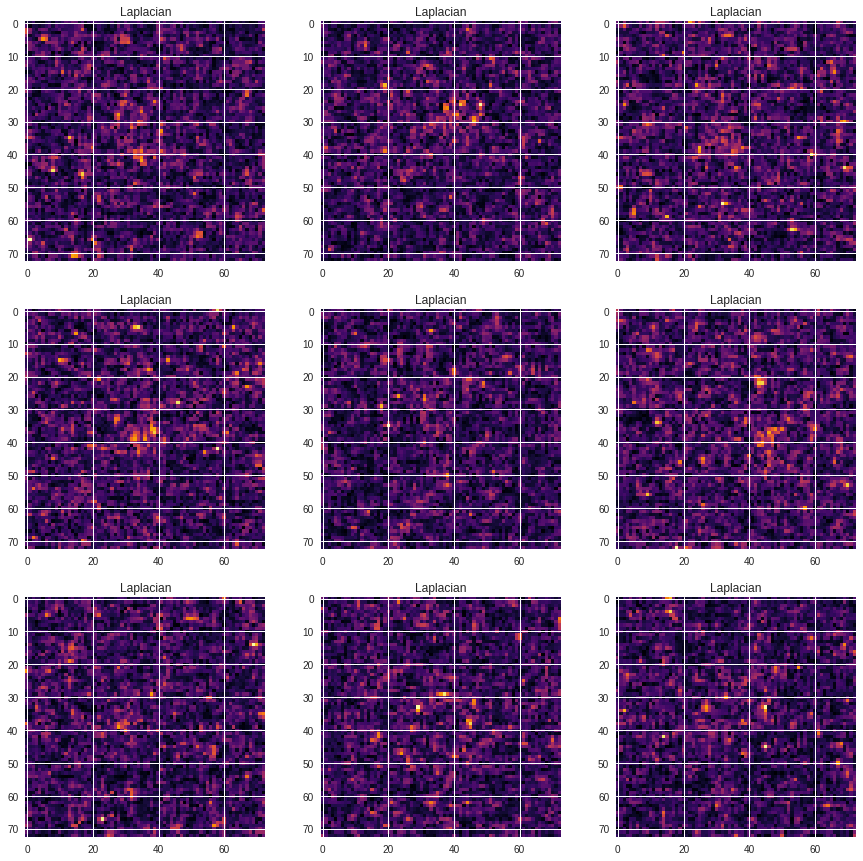

In [24]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')

plt.show()

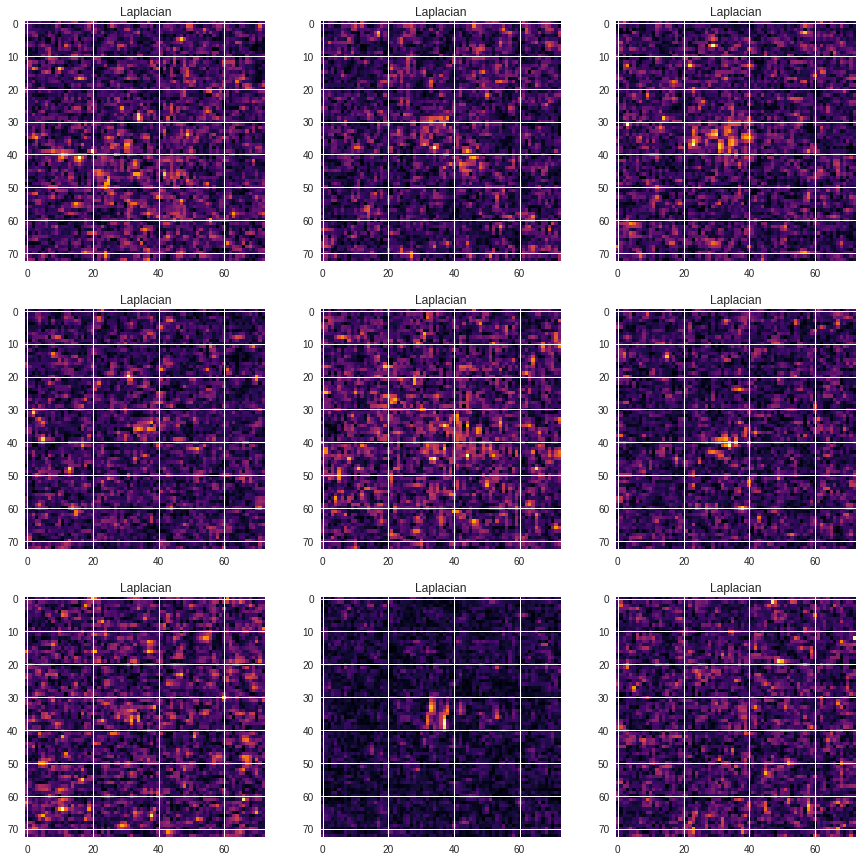

In [25]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder2,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder2,mode='valid')

    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Laplacian')
    
plt.show()

Magnitude of the Curl of Gradient¶

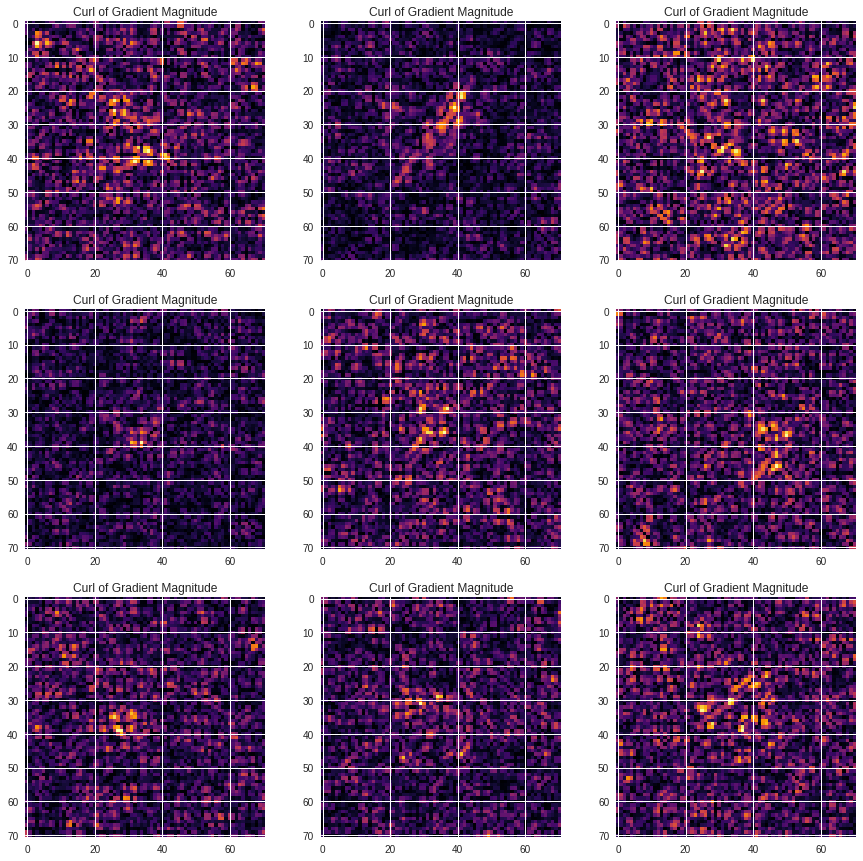

In [26]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()

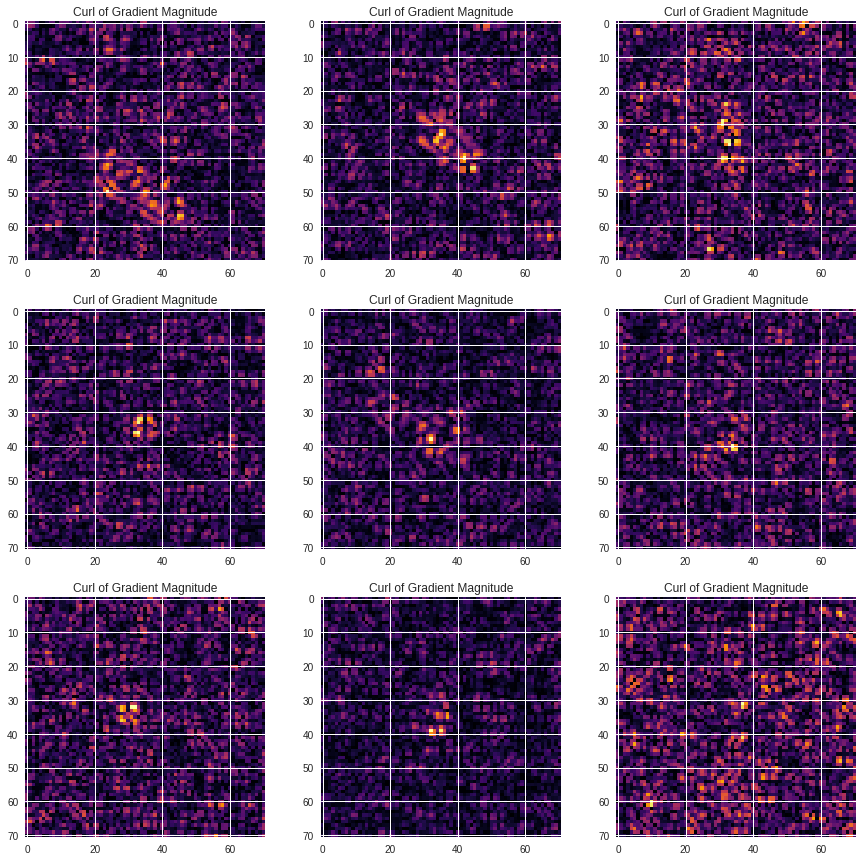

In [27]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    arrx = signal.convolve2d(arrx,yder,mode='valid')
    arry = signal.convolve2d(arry,xder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Curl of Gradient Magnitude')
    
plt.show()